# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


In [2]:
%%bash
git clone https://github.com/masa-su/pixyz.git

fatal: destination path 'pixyz' already exists and is not an empty directory.


In [3]:
!apt-get update && apt-get install ffmpeg

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 Packages [27.3 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [308 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/univ

In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install tensorboardX
!pip install -e pixyz --process-dependency-links
torch.cuda.is_available()

Obtaining file:///content/pixyz
DEPRECATION: Dependency Links processing has been deprecated and will be removed in a future release. A possible replacement is PEP 508 URL dependencies. You can find discussion regarding this at https://github.com/pypa/pip/issues/4187.
  Found existing installation: pixyz 0.0.2
    Can't uninstall 'pixyz'. No files were found to uninstall.
  Running setup.py develop for pixyz


True

# CVAE

generative process

1dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

微妙に近似できない理由：bernulli分布を仮定してるせいだと思われるので，別の分布で表現すべき

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np

from tqdm import tqdm

batch_size = 128
epochs =50#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [0]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [0]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [0]:
import torch.distributions as dist

sample_num=6000
dsigma=0.3

#sample dataset
#cを自分で定義した場合
sample_ca=torch.ones(int(sample_num/3))*-1
sample_cb=torch.ones(int(sample_num/3))*3
sample_cc=torch.ones(int(sample_num/3))*5
sample_c=torch.cat([sample_ca,sample_cb,sample_cc],dim=0)

# sample_c=torch.rand(sample_num)*100#一様分布からの場合

sample_s=dist.Normal(sample_c,dsigma).sample()
sample_o=dist.Normal(sample_s,dsigma).sample()

dc=sample_c
ds=sample_s
do=sample_o

tc=torch.rand(1000)*100
ts=dist.Normal(tc,dsigma).sample()
to=dist.Normal(ts,dsigma).sample()
tc=sample_c
ts=sample_s
to=sample_o
# print(to)

# test_loader=zip(to,tc)

train = torch.utils.data.TensorDataset(do, dc)
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(to, tc)
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

In [33]:
print(sample_c)

tensor([-1., -1., -1.,  ...,  5.,  5.,  5.])


In [0]:
o_dim = 1
c_dim = 1
s_dim = 1


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","c"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+c_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, c):
        h = F.relu(self.fc1( torch.stack([o,c],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z,y)    
class Generator(Normal):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":torch.tensor(0.3).to(device)}

#     def forward(self, s, c):
#         print(s)
#         print(c.view(1))
#         c=c.view(1)
#         print(s.shape)
#         print(c.shape)
#         print(s.size())
#         print(c.size())
#         sc=[]
#         sc.append(s)
#         sc.append(c)
#         aa=self.fc1(torch.stack(sc, 0))
#         h = F.relu(aa)
#         h = F.relu(self.fc2(h))
#         return {"probs": torch.sigmoid(self.fc3(h))}

      
    

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [35]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor(0.3).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [36]:
p = Generator()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator(
    (fc1): Linear(in_features=1, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=1, bias=True)
  )
Distribution:
  q(s|o,c) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=1, bias=True)
    (fc32): Linear(in_features=4, out_features=1, bias=True)
  )


In [37]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,c)||p_prior(s|c)]


In [38]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,c), p(o|s) 
Loss function: 
  mean(-E_q(s|o,c)[log p(o|s)] + KL[q(s|o,c)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [0]:
def train(epoch):
    train_loss = 0
    for o,c in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(dc)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [0]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [0]:
def test(epoch):
    test_loss = 0
    for o, c in test_loader:
        o = o.to(device)
        c = c.to(device)
        loss = model.test({"o": o, "c": c})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(tc)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [0]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [0]:
def plot_reconstrunction(o, c):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

Text(0.5,1,'Simulated dataset')

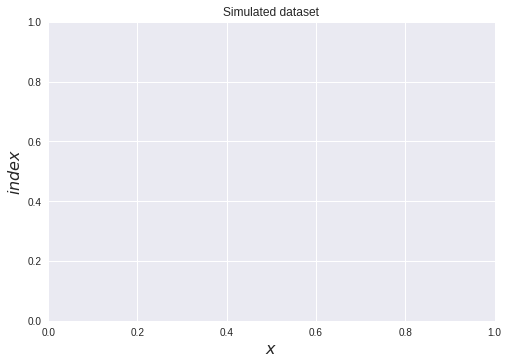

In [44]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
sample_s=dist.Normal(dc,dsigma).sample()
sample_o=dist.Normal(sample_s,dsigma).sample()

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$index$', fontsize=16)
plt.title("Simulated dataset")
# plt.xticks(np.arange(-2,6,1.0))

In [45]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": sample_o.to(device), "c": dc.to(device)}, return_all=False)
    plt.subplot(1, 2, 1)
    tru = plt.scatter(sample_s,range(sample_num),color='blue',marker='o',edgecolors="blue")
    plt.xticks(np.arange(-2,6,1.0))
    plt.ylabel('$data index$', fontsize=16)
    plt.xlabel('$s$', fontsize=16)
    plt.subplot(1, 2, 2)
    sam = plt.scatter(_s["s"],range(sample_num),color='red',marker='x',edgecolors="red")
    plt.xticks(np.arange(-2,6,1.0))
    plt.xlabel('$s$', fontsize=16)
    ims.append([tru]+[sam])
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#animation
def iinit():    
    return (ims[0])
# animation function: this is called sequentially
def animate(i):
  return (ims[i])

#plot gif
fig = plt.figure()
plt.legend(['True','Result'], loc='upper left', fontsize=16)
ani = animation.ArtistAnimation(fig, ims)
anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(ani.to_html5_video())
rc('animation', html='jshtml')
anim

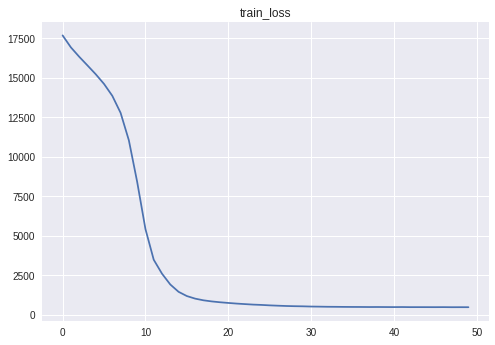

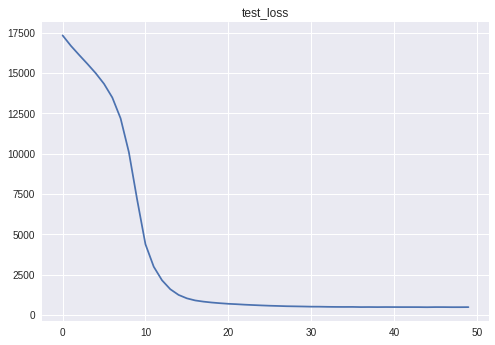

In [47]:
#plot loss    
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [0]:
# sample_num=300

# #sample dataset
# max_data=5
# min_data=-1
# sample_ca=torch.ones(int(sample_num/3))*min_data
# sample_cb=torch.ones(int(sample_num/3))*3
# sample_cc=torch.ones(int(sample_num/3))*max_data

# sample_c=torch.cat([sample_ca,sample_cb,sample_cc],dim=0)
# sample_s=dist.Normal(sample_c,dsigma).sample()
# sample_o=dist.Normal(sample_s,dsigma).sample()

# _s = q.sample_mean({"o": sample_o.to(device), "c": dc.to(device)})
# _s = q.sample({"o": sample_o.to(device), "c": sample_c.to(device)},return_all=True)
_s = q.sample_mean({"o": sample_o.to(device), "c": sample_c.to(device)})
# print(_s[10005])

In [49]:
loss=0
_ss=_s.cpu().detach().numpy()
for i in range(0,sample_num-1,1):
   loss+=np.abs(sample_s[i].numpy()-_ss[i])
print(loss/sample_num)

[0.21147369]


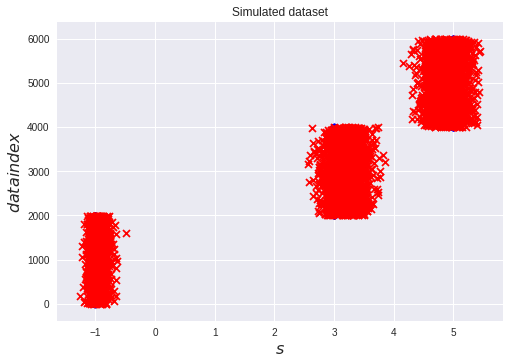

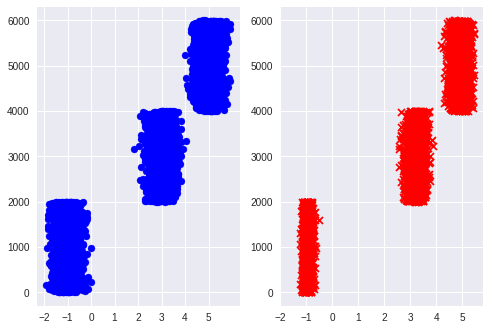

In [51]:
#show sample points

plt.scatter(sample_c,range(sample_num),color='blue',marker='o',edgecolors="blue")
plt.scatter(_s.cpu().detach().numpy(),range(sample_num),color='red',marker='x',edgecolors="red")
plt.xlabel('$s$', fontsize=16)
plt.ylabel('$dataindex$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(sample_s,range(sample_num),color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,1.0))
plt.subplot(1,2,2)
plt.scatter(_s.cpu().detach().numpy(),range(sample_num),color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,1.0))
plt.show()
